In [362]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import cv2
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [363]:
img_width, img_height = 76, 76
input_shape = (img_width, img_height, 1)
batch_size = 10
no_epochs = 25
no_classes = 2
validation_split = 0.2
verbosity = 1

In [364]:
instances = []
classes = []
for filepath in os.listdir(f'train/ht'):
    resized_image = cv2.imread(f'train/ht/{format(filepath)}', 0)
    resized_image = cv2.resize(resized_image, (img_width, img_height))
    instances.append(resized_image)
    classes.append(1)

In [365]:
for filepath in os.listdir(f'train/nht'):
    resized_image = cv2.imread(f'train/nht/{format(filepath)}', 0)
    resized_image = cv2.resize(resized_image, (img_width, img_height))
    instances.append(resized_image)
    classes.append(0)

In [366]:
v_instances = []
v_classes = []

for filepath in os.listdir(f'valid/nht'):
    resized_image = cv2.imread(f'valid/nht/{format(filepath)}', 0)
    resized_image = cv2.resize(resized_image, (img_width, img_height))
    v_instances.append(resized_image)
    v_classes.append(0)

In [367]:
for filepath in os.listdir(f'valid/ht'):
    resized_image = cv2.imread(f'valid/ht/{format(filepath)}', 0)
    resized_image = cv2.resize(resized_image, (img_width, img_height))
    v_instances.append(resized_image)
    v_classes.append(1)

In [368]:
v_classes

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [369]:
from sklearn.utils import shuffle

In [370]:
instances, classes = shuffle(instances, classes)

In [371]:
v_instances, v_classes = shuffle(v_instances, v_classes)

In [372]:
def create_model():
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Conv2D(12, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    return model

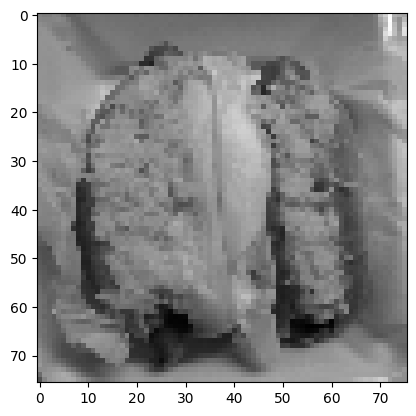

In [373]:
for i in range(len(instances)):
    if classes[i] == 1:
        plt.imshow(instances[i], cmap='gray')
        break

In [374]:
model = create_model()

In [375]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 74, 74, 4)         40        
                                                                 
 conv2d_57 (Conv2D)          (None, 72, 72, 8)         296       
                                                                 
 dropout_9 (Dropout)         (None, 72, 72, 8)         0         
                                                                 
 conv2d_58 (Conv2D)          (None, 70, 70, 12)        876       
                                                                 
 flatten_21 (Flatten)        (None, 58800)             0         
                                                                 
 dense_35 (Dense)            (None, 256)               15053056  
                                                                 
 dropout_10 (Dropout)        (None, 256)             

In [376]:
instances, classes = np.array(instances), np.array(classes)
v_instances, v_classes = np.array(v_instances), np.array(v_classes)

In [377]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [378]:
model.fit(
    instances, classes,
    validation_data=(v_instances, v_classes),
    epochs=30,
    verbose=2
)

Epoch 1/30
16/16 - 3s - loss: 19.1165 - accuracy: 0.5312 - val_loss: 6.6336 - val_accuracy: 0.6561 - 3s/epoch - 169ms/step
Epoch 2/30
16/16 - 2s - loss: 4.4766 - accuracy: 0.5473 - val_loss: 2.0773 - val_accuracy: 0.3631 - 2s/epoch - 112ms/step
Epoch 3/30
16/16 - 2s - loss: 1.4807 - accuracy: 0.5292 - val_loss: 0.7976 - val_accuracy: 0.3631 - 2s/epoch - 112ms/step
Epoch 4/30
16/16 - 2s - loss: 0.7094 - accuracy: 0.5493 - val_loss: 0.6527 - val_accuracy: 0.6688 - 2s/epoch - 112ms/step
Epoch 5/30
16/16 - 2s - loss: 0.6789 - accuracy: 0.5553 - val_loss: 0.6843 - val_accuracy: 0.4904 - 2s/epoch - 112ms/step
Epoch 6/30
16/16 - 2s - loss: 0.6709 - accuracy: 0.6117 - val_loss: 0.6770 - val_accuracy: 0.5860 - 2s/epoch - 112ms/step
Epoch 7/30
16/16 - 2s - loss: 0.6663 - accuracy: 0.5895 - val_loss: 0.6549 - val_accuracy: 0.6051 - 2s/epoch - 112ms/step
Epoch 8/30
16/16 - 2s - loss: 0.6541 - accuracy: 0.6157 - val_loss: 0.6790 - val_accuracy: 0.5796 - 2s/epoch - 111ms/step
Epoch 9/30
16/16 - 2s -